In [1]:
import pandas as pd
from trueskill import Rating, quality_1vs1, rate_1vs1, quality, rate, global_env, choose_backend,  backends, setup
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from IPython.display import display
from ipywidgets import widgets
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
#!pip install --upgrade pip
#!pip install ipywidgets

In [63]:
df = pd.read_csv('Data/Competition.csv').drop_duplicates()

In [441]:
#UTILITIES
def strip_all_strings_in_df(df_, cols_):
    for s in cols_:
        df_[s] = df_[s].apply(lambda x: x.strip())
    return df_

#LOAD DATA
def get_competition_info(df_, div_='DI'):  
    df_ = get_teams_by_division(df_, div_)                                                      
    df_ = strip_all_strings_in_df(df_, ['first_name', 'last_name', 'college', 'location', 'division', 'score'])     
    df_ = df_.groupby('compID') \
        .filter(lambda x: len(x) == 20) \
        .sort_values(['date', 'compID', 'position', 'result'], ascending=True) \
        .reset_index() \
        .iloc[:,1:]
    return df_

#GET TEAM INFO
def get_teams_by_division(df_, div_='DI'):
    df_ = df_[df_["division"] == div_].drop_duplicates() \
        .reset_index().iloc[:,1:] \
        .sort_values(sort_order, ascending=True)
    return df_

#SETTING RATINGS
def set_default_player_rating(df_, div_='DI'): 
    df_players_ = df_.loc[:, ['division',  'college', 'first_name', 'last_name', 'mu', 'sigma']].copy() \
                    .drop_duplicates()
    df_players_ = strip_all_strings_in_df(df_players_, ['division',  'college', 'first_name', 'last_name'])
    df_players_ = df_players_[df_players_.division == div_]
    df_players_.loc[:,'mu'] = Rating().mu
    df_players_['sigma'] = Rating().sigma
    df_players_ = df_players_.sort_values(['last_name', 'first_name', 'college'], ascending=True) \
        .drop_duplicates() \
        .reset_index() \
        .loc[:, ['division',  'college', 'first_name', 'last_name',  'mu', 'sigma']]
    return df_players_


#GETTING RATINGS
def get_player_ratings_from_match(df_, fname_, lname_, college_):
    player_idx = df_[(df_.first_name == fname_) \
                 & (df_.last_name == lname_) \
                 & (df_.college == college_)].index
    my_mu = df_.iloc[player_idx.item(),  df_.columns.get_loc('mu')]
    my_sigma = df_.iloc[player_idx.item(),  df_.columns.get_loc('sigma')]
    my_rating = Rating(mu=my_mu, sigma=my_sigma)
    return my_rating


def set_player_ratings_after_match(df_, fname_, lname_, college_, position_,k_factor_, rating_):
    player_idx = df_[(df_.first_name == fname_) \
                 & (df_.last_name == lname_) \
                 & (df_.college == college_)].index
    df_.iloc[player_idx,  df_.columns.get_loc('mu')] = rating_.mu + k_factor_[int(position_)-1]
    #df_.iloc[player_idx,  df_.columns.get_loc('mu')] = rating_.mu
    df_.iloc[player_idx,  df_.columns.get_loc('sigma')] = rating_.sigma
    
    my_mu = df_.iloc[player_idx.item(),  df_.columns.get_loc('mu')]
    my_sigma = df_.iloc[player_idx.item(),  df_.columns.get_loc('sigma')]
    my_rating = Rating(mu=my_mu, sigma=my_sigma)
    return my_rating


def create_ratings_from_matches(df_, k_factor_=[0,0,0,0,0], div_='DI'):
    df_matches = get_competition_info(df_, div_)
    df_players = set_default_player_rating(df_, div_)

    groups = df_matches.groupby(['date', 'compID', 'position']).groups
    counter = 0
    hist_dict = {}

    for key, value in sorted(groups.iteritems()):
        r = {}
        r_new = {}
        
        for i in range(len(value)):
            fname = df_matches.iloc[value[i], df_matches.columns.get_loc('first_name')]
            lname = df_matches.iloc[value[i], df_matches.columns.get_loc('last_name')]
            college = df_matches.iloc[value[i], df_matches.columns.get_loc('college')]
            position = df_matches.iloc[value[i], df_matches.columns.get_loc('position')]
            r[i] = get_player_ratings_from_match(df_players, fname, lname, college)

        t1 = [r[0], r[1]]
        t2 = [r[2], r[3]]

        ((r_new[0], r_new[1]), (r_new[2], r_new[3])) = rate([t1,t2], ranks=[1,0])

        for j in range(4):
            fname = df_matches.iloc[value[j], df_matches.columns.get_loc('first_name')]
            lname = df_matches.iloc[value[j], df_matches.columns.get_loc('last_name')]
            college = df_matches.iloc[value[j], df_matches.columns.get_loc('college')]
            position = df_matches.iloc[value[j], df_matches.columns.get_loc('position')]
            set_player_ratings_after_match(df_players, \
                                           fname, \
                                           lname, \
                                           college, \
                                           position, \
                                           k_factor_, \
                                           Rating(mu=(r_new[j].mu +k_factor_[i]), sigma=r_new[j].sigma  )) 

        hist_dict[counter] = df_matches.iloc[value].merge(df_players, \
                                                          left_on=['first_name', 'last_name', 'college'], 
                                                          right_on=['first_name', 'last_name', 'college'], 
                                                          how='inner')
        counter += 1

    df_match_history = pd.concat(hist_dict.values(), axis=0) \
                        .sort_values(['date','compID'], ascending=True) \
                        .reset_index() \
                        .iloc[:,1:] \
                        .rename(columns={'division_y': 'division'})
    df_match_history['name'] = df_match_history['first_name'] + " " + df_match_history['last_name']
    
    
    df_match_history = set_primary_position( df_match_history)
    
    d = {'matches': df_matches, 'match_history': df_match_history, 'players':  df_players}
    return d

def set_primary_position(df_):
    df_['count_max'] = df_.groupby(['college', 'name', 'position'])['position'].transform('count')
    df_['count at primary position'] = df_.groupby(['college','name'])['count_max'].transform('max')
    idx = df_[df_['count at primary position'] == df_['count_max']]

    #primary_position = strip_all_strings_in_df(primary_position, ['college','name'])
    primary_position = idx.loc[:, ['college','name', 'position']]
    primary_position['position'] = primary_position.groupby(['name'])['position'].transform('min')
    primary_position = primary_position.drop_duplicates()

    temp = df_.merge(primary_position, on=['college', 'name'])
    temp.rename(columns = {'position_y': 'primary position', 'position_x': 'position'}, inplace=True)
    temp = temp.loc[:,['date','compID', 'location', 'first_name', 'last_name', 'name', \
          'position', 'primary position', 'college','division' ,'result', 'mu', 'sigma' ]]
    return temp


def plot_rating_distribution(df_):
    d = df_ \
        .sort_values('date', ascending=True) \
        .groupby(['first_name', 'last_name', 'college']) \
        .last() \
        .sort_values('mu', ascending=False) \
        .reset_index()

    current_palette = sns.color_palette()

    f =  plt.figure(figsize=(30, 15))
    grid = plt.GridSpec(3, 5, wspace=.4, hspace=0.3)
    summary_ax = f.add_subplot(grid[:2, 0:])
    pos_ax = [f.add_subplot(grid[2, 4+(i*-1)], xticklabels=[], sharey=summary_ax) for i in range(5)]
    [sns.distplot( d[d['primary position'] == i+1]['mu'], ax=summary_ax,  color=current_palette[i], axlabel='Rating', hist_kws=dict(alpha=.1)) for i in range(5)]
    [sns.distplot( d[d['primary position'] == i+1]['mu'], ax=pos_ax[i], color=current_palette[i], axlabel='Position '+str(i+1))  for i in range(5)]
    return d

def get_top_players(df_, position_='all'):
    if position_ == 'all':
        df_top_players_ = df_.sort_values(['date', 'compID'], ascending=True).copy()
    else:
        df_top_players_ = df_[df_['primary position'] == position_].sort_values(['date', 'compID'], ascending=True).copy()
    df_top_players_ = df_top_players_.groupby(['first_name', 'last_name', 'college', 'division']) \
                                    .last() \
                                    .sort_values('mu', ascending=False) \
                                    .reset_index()
        
    df_top_players_['rank'] = df_top_players_.index+1
    df_top_players_ = df_top_players_.loc[:,['rank','name', 'college', 'division', 'mu', 'primary position', 'date']]
    df_top_players_.columns= ['rank','name', 'college', 'division', 'rating', 'primary position' ,'date']
    return df_top_players_


def compare_rank_to_avca_all_americans(df_):
    view = get_top_players(df_)
    view[view.name.isin([
                        "Torrey Van Winden",
                        "Tia Miric",
                        "Federica Frasca",
                        "Margherita Bianchin",
                        "Victoria Paranagua",
                        "Vanessa Freire",
                        "Claire Coppola",
                        "Kristen Nuss",
                        "Madeline Mertz",
                        "Kaylie Mchugh",
                        "Megan McNamara",
                        "Nicole McNamara",
                        "Emily Maglio",
                        "Ka'iwi Schucht",
                        "Abril Bustamante",
                        "Tina Graudina",
                        "Lily Justine",
                        "Sarah Sponcil",
                        "Deahna Kraft",
                        "Corinne Quiggle",
                        "Nele Barber",
                        "Molly Turner",
    ])]
    
def get_player_rating_history(df, a):
    temp_df = df[df['name'] == a]
    #print temp_df
    print a.upper()
    print "College: " + temp_df['college'].unique()[-1]
    print "Division: " + temp_df['division'].unique()[-1]
    print "Primary Position: " + str(temp_df['primary position'].unique()[-1])
    print "Last Rating:" + str(temp_df.groupby(['mu'])['date'].last().sort_values(ascending=False).index[0])
    f =  plt.figure(figsize=(30, 15))
    sns.lineplot(x="date", y="mu", data=temp_df)
    df_partner = pd.merge(df[df['name'] != a],temp_df, left_on=['compID', 'position', 'result'], right_on=['compID', 'position', 'result'] ) \
                    .groupby(['compID']) \
                    .first()
    df_partner.reset_index().set_index('compID')
    df_partner['Partner'] = df_partner['name_x']+' '+df_partner['mu_x'].apply(lambda x: '('+str(x)+ ')')
    df_partner = df_partner[['Partner']]
    df_summary = pd.merge(temp_df,df_partner, on='compID')
    return df_summary

# No Factor Applied

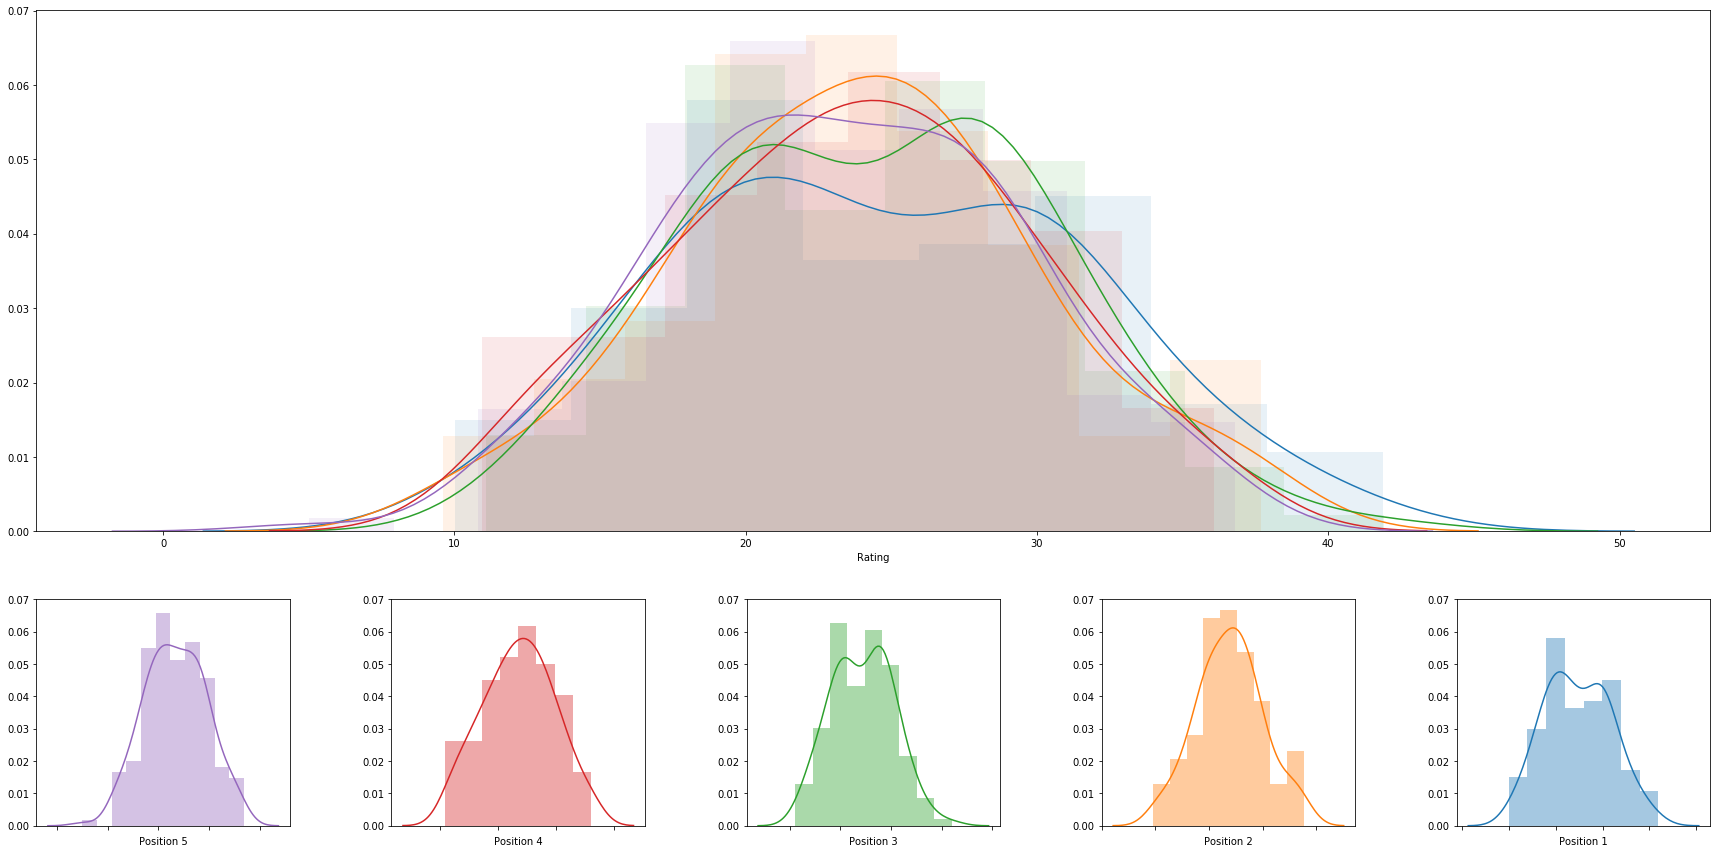

In [424]:
d = create_ratings_from_matches(df, [0,0,0,0,0])
rd = plot_rating_distribution(d['match_history'])

## Introduce overlap

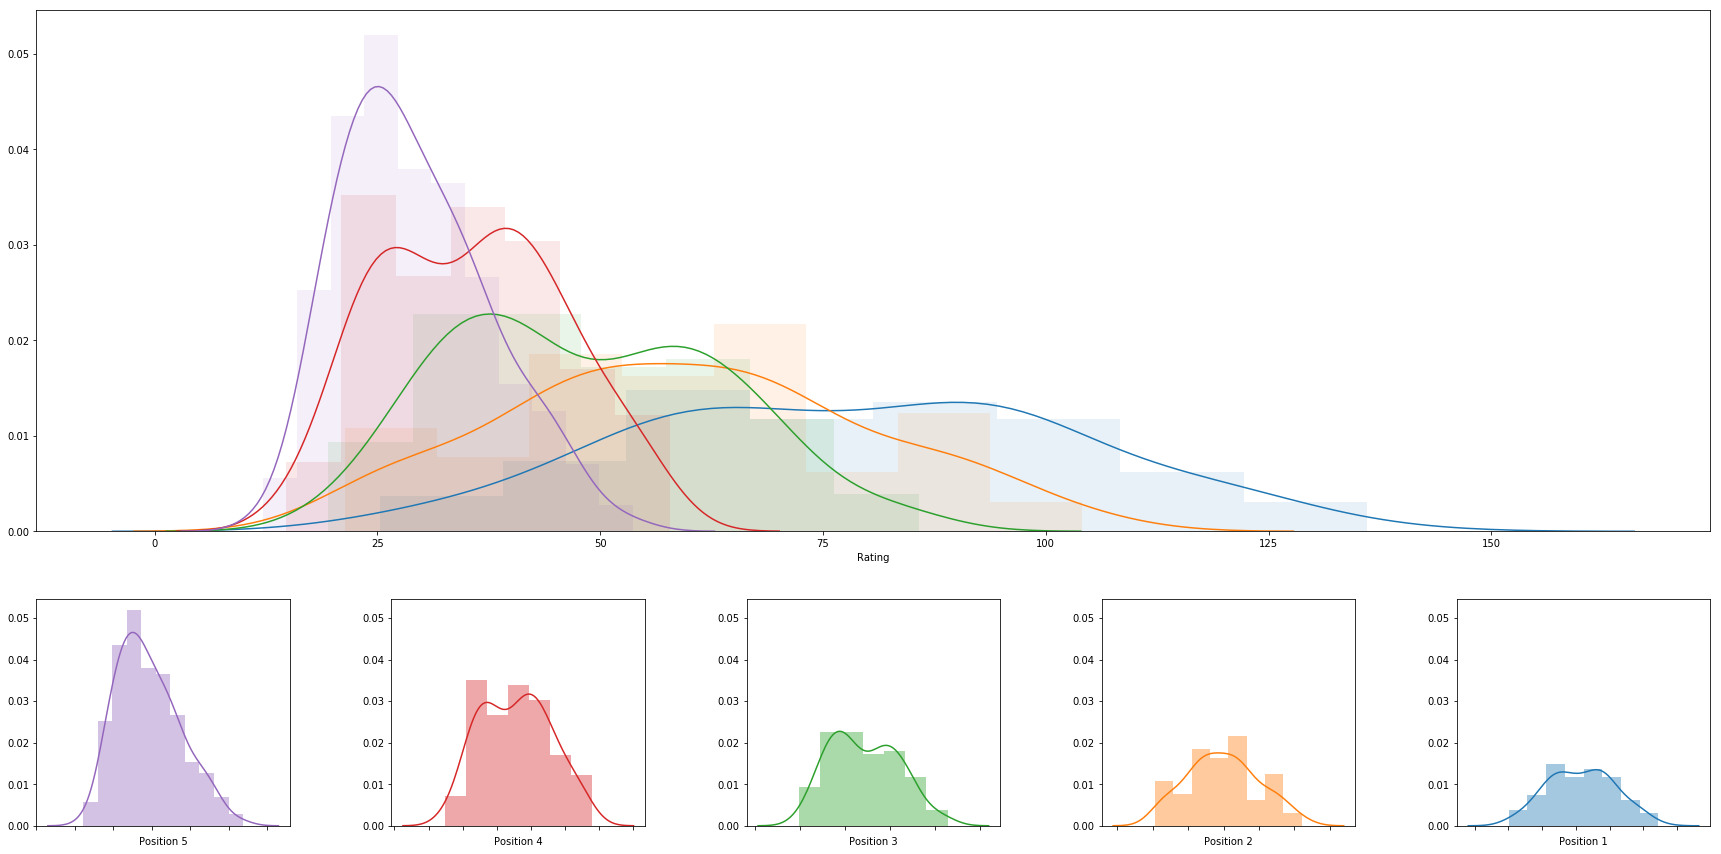

In [422]:
d = create_ratings_from_matches(df, [2.3, 1.4, 1, .25, 0])
rd = plot_rating_distribution(d['match_history'])

## Introduce more overlap

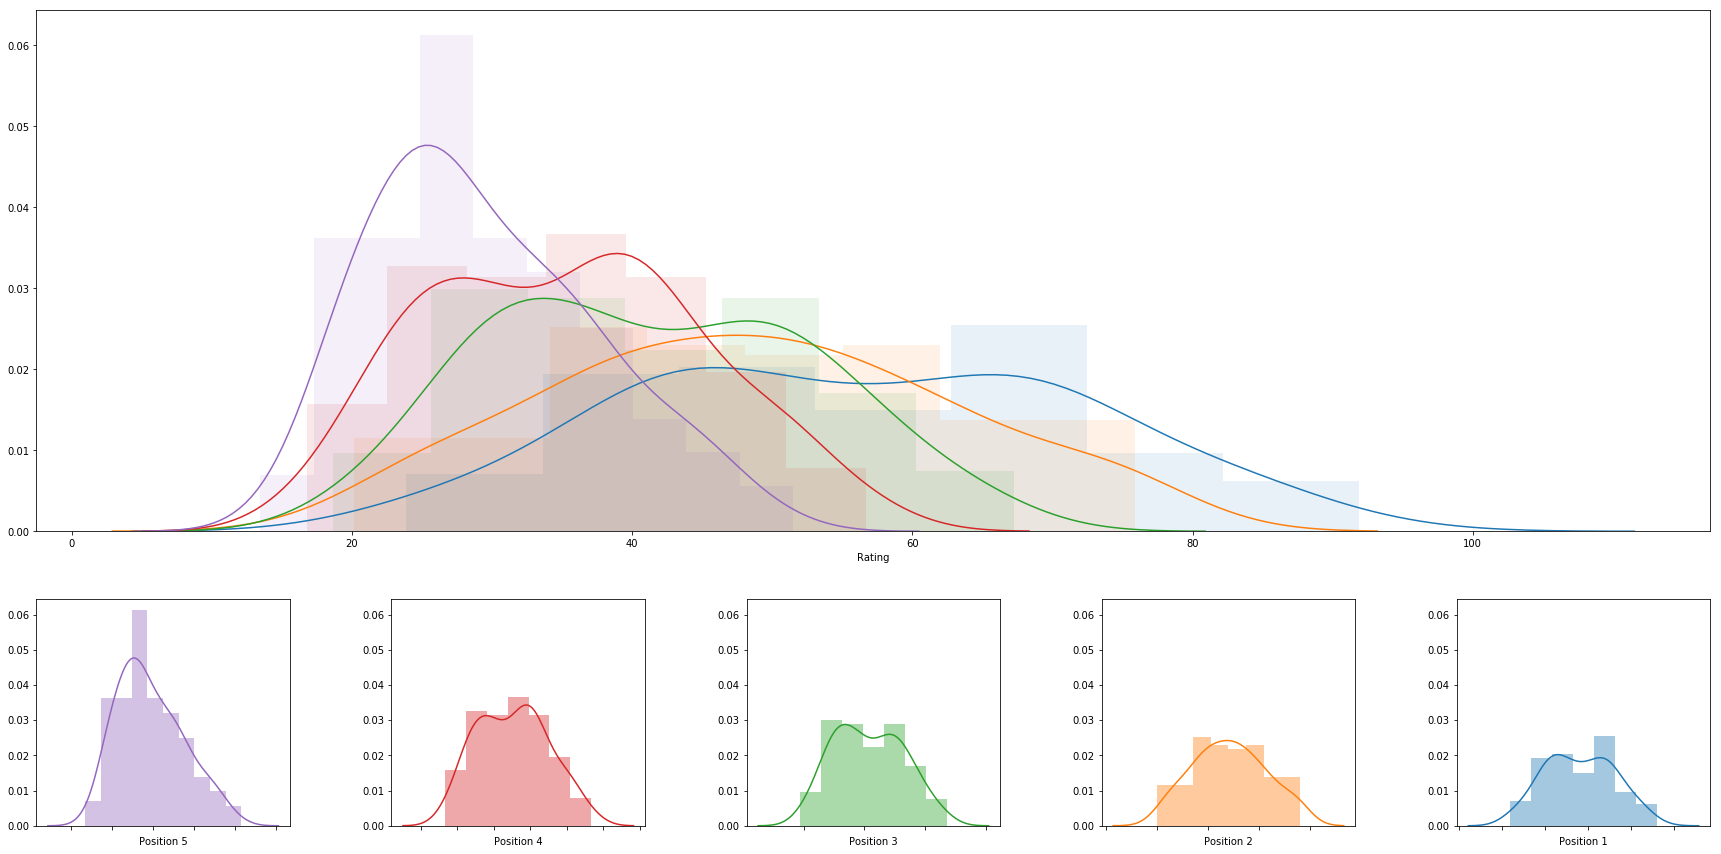

In [426]:
d = create_ratings_from_matches(df, [1.1, .9, .5, .3, 0])
rd = plot_rating_distribution(d['match_history'])

### Factor logic
- Athletes who have never played in competition for the season, shouldn't show up in ranking. As soon as they compete in a match, their initial rating is 25
- Athletes who have a win/loss record of less than 500 may have ratings lower than players who have never played in competition
- A 2.3 factor will be added to matchup results for Position 1 players to ensure that even if a match is lost, it does not result in loss of rating points
- No factor will be added to matchup results for Position 5 players.
- The remaing factors for positions 2, 3 and 4 shall be determined by limiting the overlap of the top ~25% of players in the position

# Enter the name of a player to get their rating history

Hi'ilawe Huddleston
HI'ILAWE HUDDLESTON
College: Hawaii
Division: DI
Primary Position: 5
Last Rating:37.9878368540278


,date,compID,location,first_name,last_name,name,position,primary position,college,division,result,mu,sigma,Partner
0,2018-03-08,1004,"Los Angeles, Ca",Hi'ilawe,Huddleston,Hi'ilawe Huddleston,5,5,Hawaii,DI,1,30.816461,7.506440,Allyssah Fitterer (30.8164607406)
1,2018-03-11,1077,"Manhattan Beach, Ca",Hi'ilawe,Huddleston,Hi'ilawe Huddleston,5,5,Hawaii,DI,0,27.719695,6.884970,Allyssah Fitterer (27.7196948049)
2,2018-03-18,1198,"Honolulu, Hi",Hi'ilawe,Huddleston,Hi'ilawe Huddleston,5,5,Hawaii,DI,1,33.231936,6.256573,Allyssah Fitterer (33.2319362657)
3,2018-04-08,1585,"Honolulu, Hi",Hi'ilawe,Huddleston,Hi'ilawe Huddleston,5,5,Hawaii,DI,1,34.067206,6.069901,Hannah Zalopany (40.8812885126)
4,2018-04-14,1653,"Honolulu, Hi",Hi'ilawe,Huddleston,Hi'ilawe Huddleston,5,5,Hawaii,DI,1,34.470339,6.020329,Hannah Zalopany (41.2152305312)
5,2018-04-14,1663,"Honolulu, Hi",Hi'ilawe,Huddleston,Hi'ilawe Huddleston,5,5,Hawaii,DI,1,36.400803,5.614069,Hannah Zalopany (42.0580624754)
6,2018-04-15,1679,"Honolulu, Hi",Hi'ilawe,Huddleston,Hi'ilawe Huddleston,5,5,Hawaii,DI,1,37.658041,5.339486,Hannah Zalopany (42.7088184721)
7,2018-04-15,1687,"Honolulu, Hi",Hi'ilawe,Huddleston,Hi'ilawe Huddleston,5,5,Hawaii,DI,1,37.987837,5.324630,Hannah Zalopany (43.0204724387)


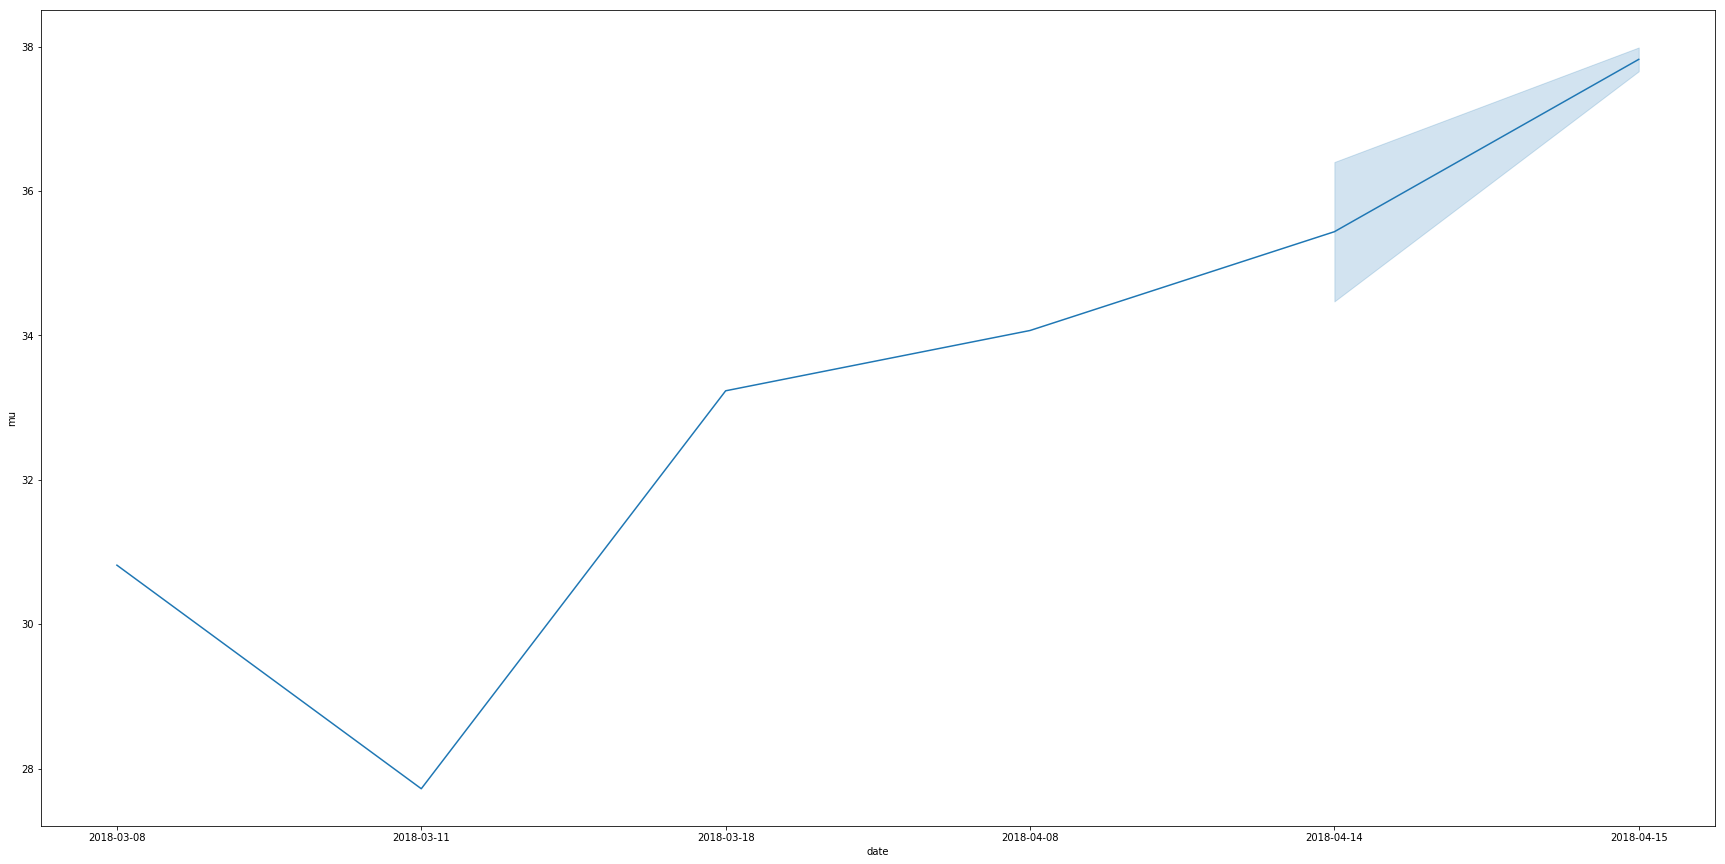

In [448]:
a = raw_input()
get_player_rating_history(d['match_history'], a)

In [447]:
get_top_players(d['match_history'],5)

,rank,name,college,division,rating,primary position,date
0,1,Francesca Goncalves,Florida State,DI,51.480706,5,2018-05-05
1,2,Maddie Ligon,LSU,DI,48.835494,5,2018-05-04
2,3,Megan Muret,UCLA,DI,48.010960,5,2018-05-06
3,4,Izzy Carey,UCLA,DI,48.010960,5,2018-05-06
4,5,Taija Thomas,FIU,DI,46.443657,5,2018-05-04
5,6,Maddie Micheletti,Cal,DI,46.379401,5,2018-04-28
6,7,Hannah Zalopany,Hawaii,DI,45.588290,5,2018-05-06
7,8,Grace Campbell,Cal,DI,44.920336,5,2018-04-28
8,9,Makenna Martin,Arizona,DI,44.693228,5,2018-04-27
9,10,Eva Torruella,Florida State,DI,44.468760,5,2018-04-22


In [451]:
d['match_history'].head(5)

,date,compID,location,first_name,last_name,name,position,primary position,college,division,result,mu,sigma
0,2018-02-23,800,"Deland, FL",Tiffany,Creamer,Tiffany Creamer,1,2,Georgia State,DI,0,23.291677,7.774363
1,2018-02-23,802,"Deland, FL",Tiffany,Creamer,Tiffany Creamer,1,2,Georgia State,DI,0,22.304248,7.328660
2,2018-02-24,824,"Deland, FL",Tiffany,Creamer,Tiffany Creamer,1,2,Georgia State,DI,1,29.036735,6.762030
3,2018-03-02,945,"St. Augustine, Fl",Tiffany,Creamer,Tiffany Creamer,1,2,Georgia State,DI,1,31.578178,6.521509
4,2018-03-03,935,"St. Augustine, Fl",Tiffany,Creamer,Tiffany Creamer,1,2,Georgia State,DI,1,33.681336,6.343739


# Matchups -  Probability of wins

In [493]:
def predict_match(compid_, df_):
    r = {}
    v = {}
    t = {}
    
    match = df_[df_['compID'].astype(int) == compid_]
    groups = match.groupby(['date', 'compID', 'position']).groups
    counter = 0
    hist_dict = {}

    for key, value in sorted(groups.iteritems()):
        for i in range(len(value)):
            print i, value
            print match.iloc[value[i], matches.columns.get_loc('name')]
            print match.iloc[value[i], matches.columns.get_loc('college')]
            print match.iloc[value[i], matches.columns.get_loc('position')]
    
        #win_prob = win_probability(t[1], t[2])
    return 

matches = d['match_history']
predict_match(800, matches)



{('2018-02-23', 800, 1): Int64Index([0, 37, 74, 107], dtype='int64'),
 ('2018-02-23', 800, 2): Int64Index([140, 159, 188, 194], dtype='int64'),
 ('2018-02-23', 800, 3): Int64Index([226, 247, 277, 310], dtype='int64'),
 ('2018-02-23', 800, 4): Int64Index([343, 349, 381, 414], dtype='int64'),
 ('2018-02-23', 800, 5): Int64Index([447, 456, 488, 498], dtype='int64')}

In [ ]:
    for idx, rows in match.iterrows():
        r = {}
        p_lookup = {}
        t = {}
        for i in range(1,5):
            p_lookup[i] = lookup_player_rating(rows.iloc[i],[rows.iloc[5], rows.iloc[6]], df_player_rating )
            r[i] = Rating(mu=p_lookup[i].mu, sigma=p_lookup[i].sigma)
    
        t[1] = [r[1], r[2]]
        t[2] = [r[3], r[4]]
        
        win_prob = win_probability(t[1], t[2])
    
        
        match.loc[idx, 'Probability'] = win_prob 
        #print win_prob
        if (win_prob >.60):
            match.loc[idx, 'Predicted Winner'] = p_lookup[1]['Team'] 
            match.loc[idx, 'Distance From Draw'] = (win_prob - .60)
            match.loc[idx, 'T1 Win'] = 1
        elif (win_prob <.40):
            match.loc[idx, 'Predicted Winner'] = p_lookup[3]['Team'] 
            match.loc[idx, 'Distance From Draw'] = (.40-win_prob )
            match.loc[idx, 'T1 Win'] = 0
        else:
            match.loc[idx, 'Predicted Winner'] = 'Draw'
            match.loc[idx, 'Distance From Draw'] = 0
            match.loc[idx, 'T1 Win'] = .5

In [ ]:




    groups = df_matches.groupby(['date', 'compID', 'position']).groups
    counter = 0
    hist_dict = {}

    for key, value in sorted(groups.iteritems()):
        r = {}
        r_new = {}
        
        for i in range(len(value)):
            fname = df_matches.iloc[value[i], df_matches.columns.get_loc('first_name')]
            lname = df_matches.iloc[value[i], df_matches.columns.get_loc('last_name')]
            college = df_matches.iloc[value[i], df_matches.columns.get_loc('college')]
            position = df_matches.iloc[value[i], df_matches.columns.get_loc('position')]
            r[i] = get_player_ratings_from_match(df_players, fname, lname, college)

        t1 = [r[0], r[1]]
        t2 = [r[2], r[3]]

        ((r_new[0], r_new[1]), (r_new[2], r_new[3])) = rate([t1,t2], ranks=[1,0])

        for j in range(4):
            fname = df_matches.iloc[value[j], df_matches.columns.get_loc('first_name')]
            lname = df_matches.iloc[value[j], df_matches.columns.get_loc('last_name')]
            college = df_matches.iloc[value[j], df_matches.columns.get_loc('college')]
            position = df_matches.iloc[value[j], df_matches.columns.get_loc('position')]
            set_player_ratings_after_match(df_players, \
                                           fname, \
                                           lname, \
                                           college, \
                                           position, \
                                           k_factor_, \
                                           Rating(mu=(r_new[j].mu +k_factor_[i]), sigma=r_new[j].sigma  )) 

In [454]:
def win_probability(team1_, team2_):
    delta_mu = sum(r.mu for r in team1_) - sum(r.mu for r in team2_)
    sum_sigma = sum(r.sigma ** 2 for r in itertools.chain(team1_, team2_))
    size = len(team1_) + len(team2_)
    denom = math.sqrt(size * (BETA * BETA) + sum_sigma)
    ts = global_env()
    return ts.cdf(delta_mu / denom)

matches = d['match_history']
matches[(matches.compID == 800) & (matches.position == 1)]

,date,compID,location,first_name,last_name,name,position,primary position,college,division,result,mu,sigma
0,2018-02-23,800,"Deland, FL",Tiffany,Creamer,Tiffany Creamer,1,2,Georgia State,DI,0,23.291677,7.774363
37,2018-02-23,800,"Deland, FL",Brooke,Weiner,Brooke Weiner,1,2,Georgia State,DI,0,23.291677,7.774363
74,2018-02-23,800,"Deland, FL",Ali,Denney,Ali Denney,1,1,South Carolina,DI,1,29.508323,7.774363
107,2018-02-23,800,"Deland, FL",Shannon,Williams,Shannon Williams,1,1,South Carolina,DI,1,29.508323,7.774363


In [ ]:


def actual_match(compid_, df_):
    return df_[df_['Compid'].astype(int) == compid_].groupby('Winner')['Position'].count()

actual_match(1863, df_matchups)

def predict_match(compid, df):
    match = df[df['Compid'].astype(int) == compid].copy().reset_index().iloc[:,1:]
    for idx, rows in match.iterrows():
        r = {}
        p_lookup = {}
        t = {}
        for i in range(1,5):
            p_lookup[i] = lookup_player_rating(rows.iloc[i],[rows.iloc[5], rows.iloc[6]], df_player_rating )
            r[i] = Rating(mu=p_lookup[i].mu, sigma=p_lookup[i].sigma)
            #match[i] = r[i]
    
        t[1] = [r[1], r[2]]
        t[2] = [r[3], r[4]]
        
        win_prob = win_probability(t[1], t[2])
    
        
        match.loc[idx, 'Probability'] = win_prob 
        #print win_prob
        if (win_prob >.60):
            match.loc[idx, 'Predicted Winner'] = p_lookup[1]['Team'] 
            match.loc[idx, 'Distance From Draw'] = (win_prob - .60)
            match.loc[idx, 'T1 Win'] = 1
        elif (win_prob <.40):
            match.loc[idx, 'Predicted Winner'] = p_lookup[3]['Team'] 
            match.loc[idx, 'Distance From Draw'] = (.40-win_prob )
            match.loc[idx, 'T1 Win'] = 0
        else:
            match.loc[idx, 'Predicted Winner'] = 'Draw'
            match.loc[idx, 'Distance From Draw'] = 0
            match.loc[idx, 'T1 Win'] = .5
        
    
    return match

_df = {}
temp = None
for a in range(780, 1870):
    print a,
    _df = predict_match(a, df_matchups)
    _df = pd.concat([_df, temp], axis=0)
    temp = _df


total_no_draw = len(_df[_df['Winner'] != 'Draw'])
accurate = len(_df[_df['Winner'] == _df['Predicted Winner']])
print accurate, total_no_draw, accurate*100/total_no_draw

_df



In [ ]:
# Predict a Match

ef predictMatch(_compid, _df):
    _match = df_all_matchups[df_all_matchups['CompID'] == _compid].iloc[:,0:5]
    wins = {}

    for i in range(0,len(_match)):
        r = [Rating(lookupPlayerRating(_match.iloc[i,j], predict_ranking))  for j in range(1,5)]

        t1 = [r[0], r[1]]
        t2 = [r[2], r[3]]

        win_prob = win_probability(t1, t2)

        #print [(_match.iloc[i,j]+"("+lookupPlayer(_match.iloc[i,j], _df)['Team']+")") for j in range(1,5) ],

        if win_prob > .50:
            val = max(lookupPlayer(_match.iloc[i, 1], _df)['Team'], lookupPlayer(_match.iloc[i, 2], _df)['Team'])
            #print val, ' favored'
            try:
                wins[val] += 1
            except:
                wins[val] =  1
        elif win_prob < .50:
            val = max(lookupPlayer(_match.iloc[i, 3], _df)['Team'], lookupPlayer(_match.iloc[i, 4], _df)['Team'])
            #print val, ' favored'
            try:
                wins[val] += 1
            except:
                wins[val] =  1
        else:
            val = 'Draw'
            try:
                wins[val] += 1
            except:
                wins[val] =  1
                
    match_winner = max(wins.iteritems(), key=operator.itemgetter(1))[0]      
    
    return wins, match_winner

print "Predicted:" + str(predictMatch(1816, df_player_ratings))
print "Actual:" + str(actualMatch(1816, df_player_ratings))